In [41]:
# Importing required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates

In [42]:
# define the stock ticker and date ranges
ticker='QUBT'
start_date='2010-01-01'
end_date='2025-07-31'
training_data_start_date='2010-01-01'
training_data_end_date='2022-12-31'
validation_data_start_date='2023-01-01'
validation_data_end_date='2023-12-31'
test_data_start_date='2024-01-01'
test_data_end_date='2024-12-31'
prediction_start_date='2025-01-01'
# Download historical data for a stock from Yahoo Finance
df = yf.download(ticker, start=start_date, end=end_date)



/tmp/ipykernel_26680/2301992372.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [43]:
# explore the data
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,QUBT,QUBT,QUBT,QUBT,QUBT
count,3917.000000,3917.000000,3917.000000,3917.000000,3.917000e+03
mean,6.871598,7.353848,6.323486,6.890392,1.680284e+06
std,22.503278,23.883802,20.706442,22.667655,1.051295e+07
min,0.015000,0.015000,0.015000,0.015000,0.000000e+00
25%,0.699000,0.729000,0.666000,0.700000,0.000000e+00
50%,2.600000,2.700000,2.450000,2.600000,1.250000e+02
75%,5.800000,6.000000,5.330000,5.800000,1.086000e+05
max,238.000000,240.000000,220.000000,240.000000,2.326194e+08


In [44]:
# Split data into training (2010-2020) and validation (2020-2023) sets
# training_data = spy['Adj Close']['2010-01-01':'2020-12-31']
# validation_data = spy['Adj Close']['2021-01-01':'2023-01-01']

training_data = df['Close'][training_data_start_date:training_data_end_date]
validation_data = df['Close'][validation_data_start_date:validation_data_end_date]

# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

In [45]:
# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

In [46]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [47]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

/home/tshen/dp-100/mslearn-azure-ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 3.1697e-04 - val_loss: 1.2258e-05
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.2755e-04 - val_loss: 1.8129e-05
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.2560e-04 - val_loss: 3.1362e-05
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 1.1838e-04 - val_loss: 1.5606e-05
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1345e-04 - val_loss: 2.9779e-06
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.1360e-04 - val_loss: 8.4056e-07
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 8.5759e-05 - val_loss: 4.0946e-06
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.8905e-05 - val_loss: 3.8554e-05
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 1.0994e-04 - val_loss: 1.7034e-06
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.0056e-04 - val_loss: 5.8183e-07
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━

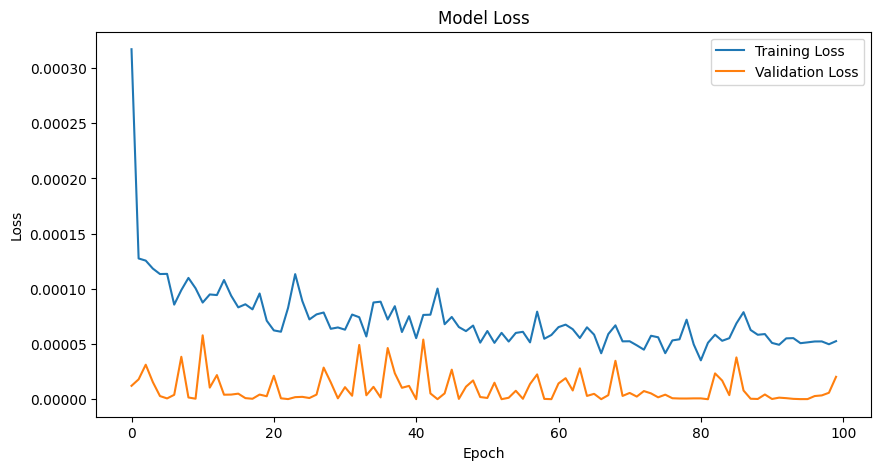

In [49]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Download test data for SPY from Yahoo Finance
# spy_test = yf.download('SPY', start='2023-01-01', end='2023-07-31')
df_test = yf.download(ticker, start=test_data_start_date, end=test_data_end_date)

# Use 'Adj Close' prices as the test data
# real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)
real_stock_price = df_test['Close'].values.reshape(-1, 1)

/tmp/ipykernel_26680/558871898.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(ticker, start=test_data_start_date, end=test_data_end_date)
[*********************100%***********************]  1 of 1 completed


In [51]:
# Preparing Test Data
# dataset_total = pd.concat((spy['Adj Close'], spy_test['Adj Close']), axis=0)
dataset_total = pd.concat((df['Close'], df_test['Close']), axis=0)
# inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values

inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [52]:
# Making Predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


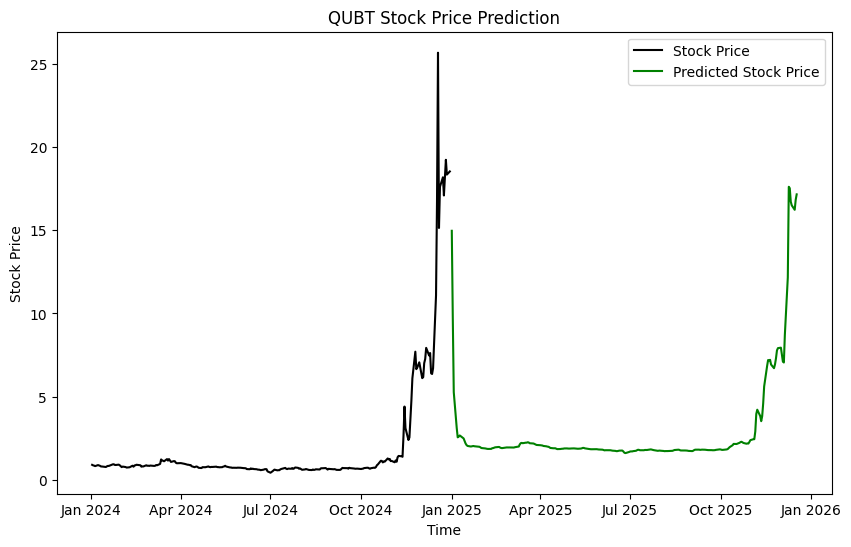

In [53]:
# Prepare dates for the predicted stock prices
date_range = pd.date_range(start=prediction_start_date, periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
# plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
# plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
# plt.title('SPY Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('SPY Stock Price')

plt.plot(df_test.index, real_stock_price, color='black', label='Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()